## Exploration_08. 인물사진
### 순서
1. 개인 사진을 이용한 인물사진 완성<br>
 1-1. 사람의 몸에 물건이 있을 때의 인식 여부<br>
 1-2. 물체가 사람과 가까히 있을 때의 인식 여부
2. 고양이 사진을 이용한 인물사진 완성
3. 배경전환 사진 완성
4. 문제점 해결방안
5. 회고

In [44]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [45]:
import os
# 각종 사진 load
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/jjs2.jpg'  # 본인 사진
img_path_3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/jjs3.jpg'  # 본인 사진
img_path_4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/jjs4.jpg'  # 본인 사진
img_path_cat = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg' # 고양이 사진
img_path_CA = os.getenv('HOME')+'/aiffel/human_segmentation/images/CA.jpg' # 캡틴 아메리카 사진
img_path_war = os.getenv('HOME')+'/aiffel/human_segmentation/images/war.jpg' # 전쟁 배경 사진

# path 설정
img_orig = cv2.imread(img_path)
img_orig_3 = cv2.imread(img_path_3)
img_orig_4 = cv2.imread(img_path_4)
img_orig_cat = cv2.imread(img_path_cat)
img_orig_CA = cv2.imread(img_path_CA)
img_orig_war = cv2.imread(img_path_war)

In [46]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [47]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [48]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1440, 1080, 3) (513, 384, 3) 15


In [49]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### Step 1. 본인 사진을 이용한 인물사진 완성

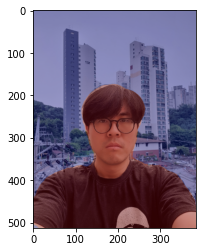

In [50]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

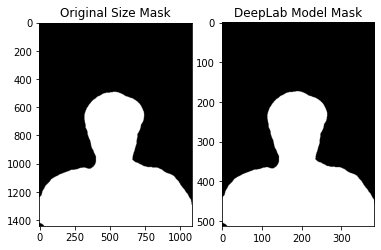

In [51]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')
ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

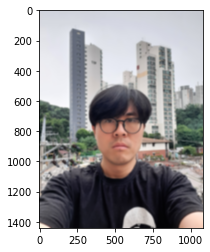

In [52]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

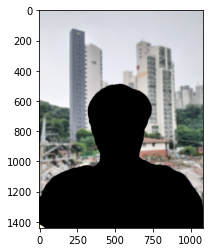

In [53]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

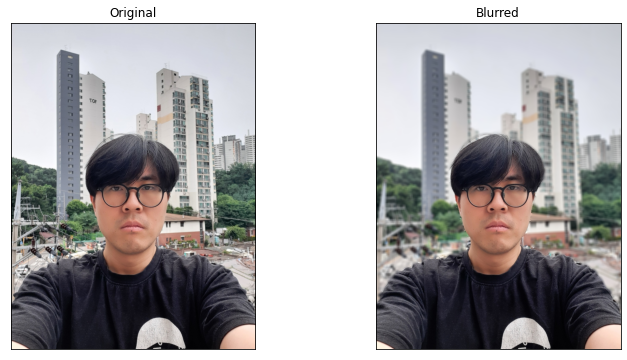

In [54]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[0].set_title('Original')
ax[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))   # 배경 처리 전의 '원본사진'
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_title('Blurred')
ax[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) # 배경이 blur 처리 된 '인물사진'
plt.show()

* 문제 없이 사람만 인식이 되었고, 따라서 사람을 제외하고 배경만 정확히 흐리게 처리 된 것을 볼 수 있다.
* 이 사진처럼 배경과의 거리가 좀 떨어져 있는 상황외에 다른 상황에서는 어떤식으로 처리 되는지 확인 해보고자 이어서 몇가지 테스트를 진행 해 보았다.

### Step 1-1. 사람의 몸에 물건이 있을 때의 인식 여부

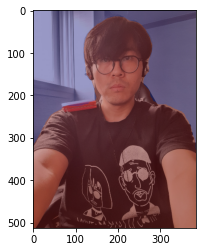

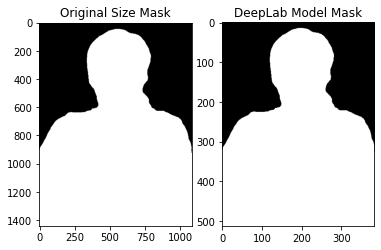

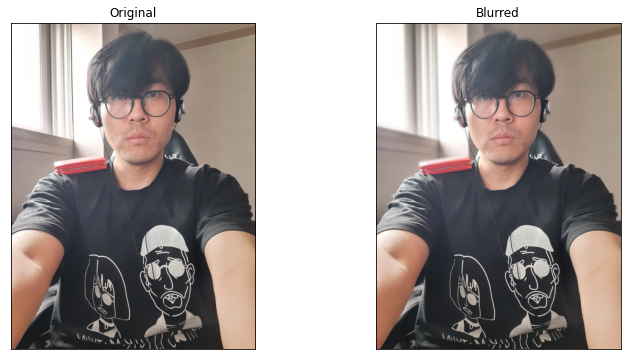

In [55]:
img_resized, seg_map = MODEL.run(img_orig_3) # Image resizing

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 사람 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig_3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')
ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

img_orig_blur = cv2.blur(img_orig_3, (13,13)) # image blur 처리, (13,13)은 blurring  kernel size 

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

f, ax = plt.subplots(1, 2, figsize=(12, 6))
img_concat = np.where(img_mask_color==255, img_orig_3, img_bg_blur)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[0].set_title('Original')
ax[0].imshow(cv2.cvtColor(img_orig_3, cv2.COLOR_BGR2RGB))   # 배경 처리 전의 '원본사진'
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_title('Blurred')
ax[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) # 배경이 blur 처리 된 사진
plt.show()

* 먼저 사람의 몸에 물건이 올라와 있는 경우 이를 따로 구분하지는 못하는 것 같다.
* 그리고 오른팔과 몸통사이의 공간도 함께 인식해버리는 문제가 있다.
* 사진상의 빨간색 통에서 위쪽 부분만 처리가 되고 앞족쪽은 그대로 인걸로 봐서 거리 외의 다른 요소(색깔)로는 구
분하지는 못하는 것 같다.

### Step 1-2. 물체가 사람과 가까히 있을 때의 인식 여부

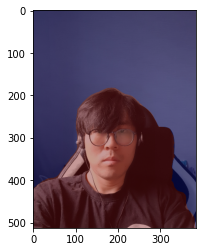

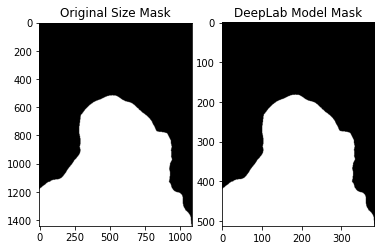

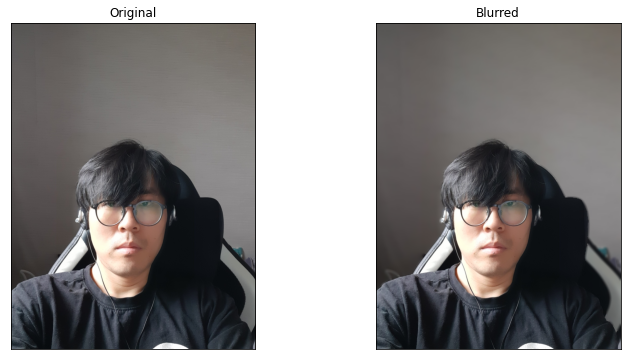

In [56]:
img_resized, seg_map = MODEL.run(img_orig_4) # Image resizing

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 사람 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig_4.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')
ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

img_orig_blur = cv2.blur(img_orig_4, (13,13)) # image blur 처리, (13,13)은 blurring  kernel size 

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

f, ax = plt.subplots(1, 2, figsize=(12, 6))
img_concat = np.where(img_mask_color==255, img_orig_4, img_bg_blur)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[0].set_title('Original')
ax[0].imshow(cv2.cvtColor(img_orig_4, cv2.COLOR_BGR2RGB))   # 배경 처리 전의 '원본사진'
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_title('Blurred')
ax[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) # 배경이 blur 처리 된 사진
plt.show()

* 다음 테스트로 의자에 몸을 최대한 붙여서 찍은 사진으로 진행 해 보았다.
* 의자를 보면 거리가 조금 떨어진 오른쪽은 제대로 흐리게 처리 된 반면, 몸과 가까운 의자의 왼쪽 부분과 목배게는 사람과 함께 인식하는 걸 볼 수 있다.
* 즉, 배경이라고 인식 되기 위한 최소거리가 존재하고 이를 만족하는 것에 한하여 처리가 진행 된다고 여겨진다.
* 이런 문제들을 해결하기 위해서는 좀 더 거리에 민감하게 작동하는 방식을 사용하던지, 아니면 위에 Label_name 리스트에 들어있는 각 label 들에 대한 기본 형태를 미리 학습 시켜두고 해당 label을 설정하고 이미지 판독을 실시 했을 때, 해당 label의 형태에서 크게 벗어나는 부분은 모두 제거하는 식으로 인식을 시키면 좀 더 정확하게 인식되지 않을까 한다.
* 단순 거리만으로는 이런 디테일한 부분까지 계산해 내기가 쉽지 않다고 생각한다.

### Step 2. 고양이 사진을 이용한 사진 완성

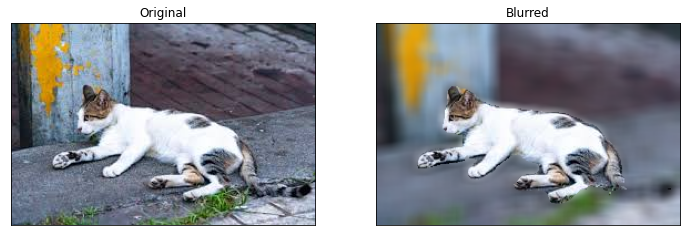

In [57]:
img_resized, seg_map = MODEL.run(img_orig_cat) # Image resizing

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 고양이(8) 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

img_mask_up = cv2.resize(img_mask, img_orig_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

img_orig_blur = cv2.blur(img_orig_cat, (13,13)) # image blur 처리, (13,13)은 blurring  kernel size 

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

f, ax = plt.subplots(1, 2, figsize=(12, 6))
img_concat = np.where(img_mask_color==255, img_orig_cat, img_bg_blur)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[0].set_title('Original')
ax[0].imshow(cv2.cvtColor(img_orig_cat, cv2.COLOR_BGR2RGB))   # 배경 처리 전의 '원본사진'
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_title('Blurred')
ax[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) # 배경이 blur 처리 된 '고양이사진'
plt.show()

* 사람 사진을 사용했을 때와 마찬가지로 고양이 사진도 잘 구분해 내는 것을 볼 수 있다.
* 하지만 꼬리 부분을 절반정도 인식하지 못했는데 배경의 갈라진 바닥의 선과 꼬리의 선이 거의 같은 위치에 있어서 이를 배경으로 인식하고 짤라 낸 것이 아닌가 하는 생각이 든다.

### Step 3. 배경전환 사진 완성

In [78]:
# 이미지 사이즈 변경

img_resized, seg_map = MODEL.run(img_orig_CA) # CA(Captain America) Image resizing
img_resized_war, seg_map_war = MODEL.run(img_orig_war) # Background Image resizing

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 사람(15) 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

img_mask_up = cv2.resize(img_mask, img_orig_CA.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
img_mask_up_war = cv2.resize(img_mask, img_orig_war.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# Blur 처리
img_orig_blur = cv2.blur(img_orig_CA, (13,13)) # image blur 처리, (13,13)은 blurring  kernel size 
img_orig_blur_war = cv2.blur(img_orig_war, (13,13)) # image blur 처리, (13,13)은 blurring  kernel size 

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_mask_color_war = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_mask_war = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
img_bg_blur_war = cv2.bitwise_and(img_orig_blur_war, img_bg_mask_war)


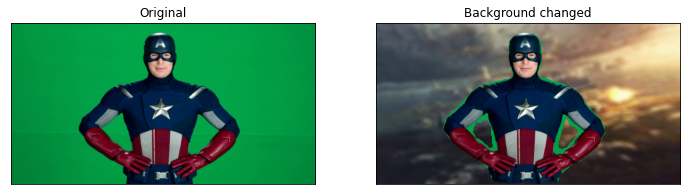

In [79]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
img_concat = np.where(img_mask_color==255, img_orig_CA, img_bg_blur_war)
# height, width = img_bg_blur.shape[:2]
# center = (width//2, height//2)
# seamless_concat = cv2.seamlessClone(img_orig_CA, img_bg_blur_war, img_mask, center, cv2.MIXED_CLONE)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[0].set_title('Original')
ax[0].imshow(cv2.cvtColor(img_orig_CA, cv2.COLOR_BGR2RGB))   # 배경 처리 전의 '원본사진'
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_title('Background changed')
ax[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) # Blurred 처리 된 다른 배경으로 바뀐 사진
plt.show()

* 이번 사진에서 형성된 mask의 형태를 명확하게 볼 수 있다. 기본적으로 사람을 인식함에 있어서 정확하게 사람의 형태를 따라서 인식 되는것이 아니라 약간의 background가 포함되어 상당히 지저분하게 만들어 진 것을 알 수 있다.  앞서 진행했던 '본인사진'을 이용한 결과나, '고양이사진'을 이용한 사진에서도 마찬가지의 현상이 발생 했었다.
* 따라서 이 부분을 개선하여 하나의 명확한 형태로 인식하도록 만들 필요가 있어 보이며, 이런 문제가 해결 된 경우 겹쳐 있는 여러개의 물체를 개별로 인식하지 못하는 등의 문제들 또한 해결 될 것으로 보인다.

### Step 4. 문제점 해결 방안

#### 1. masking filter를 blur 대신 bilateralFilter로 변경 
* bilateralFilter를 사용하면 masking 하고자 하는 이미지를 더 선명하게 나타내주며 이미지의 경계를 구분하는데 좋은 성능을 발휘하는 것으로 알고있다. 따라서 단순히 blur처리 하는 것 보다 좀 더 명확한 masking 이 가능할 것으로 생각 된다.

#### 2. DeepLab 활용
* Image masking 의 accuracy를 높이기 위한 방법으로 DeepLab이 사용 될 수 있다고 한다.
* 이는 몇 단계를 거쳐서 진행 되는데 하나씩 살펴보도록 하자.

#### 2-1. Atrous convolution
* 기존의 convolution 방식에 density를 높여서 더 많은 연산이 진행되도록 하는 방식.
* 아래의 이미지 처럼 sparse하게 학습되는 상태에서 설정 된 rate의 수치에 따라 추가 학습이 진행 되도록 하므로써 더 정확도가 높은 결과를 얻을 수 있도록 한다.

<작동원리>
![](https://t1.daumcdn.net/cfile/tistory/99107B33598343D524)

<결과>
* 일반 convolution 방식과 atrous convolution 방식의 이미지를 비교해 보면 그 정확도 및 선명도의 차이를 확실히 느낄 수 있다.

![](https://t1.daumcdn.net/cfile/tistory/99B70033598344A324)

#### 2-2.  Atrous Spatial Pyramid Pooling (ASPP)
* 위의 atrous convolution 방식에서 rate 수치를 조절하며 학습을 진행한다고 했는데, 그렇게 여러가지 rate에 대해 학습된 결과들을 모두 종합하는 과정을 ASPP라고 한다.
* 따라서 이런 추가적인 과정들에 의한 전체적인 학습의 양은 증가하겠지만 결과적으로 명확하고 정확한 이미지를 얻을 수 있게된다.

<작동원리>
![](https://t1.daumcdn.net/cfile/tistory/99DCFD33598348311E)


#### 2-3. Fully connected CRF(Conditional Random Field)
* CRF는 특정 수식에 따른 작업을 반복적으로 수행함으로써 좀 더 명확한 이미지를 얻을 수 있도록 해 주는 방식이다. 
* 반복 횟수에 따른 변화는 아래의 이미지와 같다.
![](https://t1.daumcdn.net/cfile/tistory/999FF63359834AE52D)

* CRF가 진행되는 좀 더 상세한 방식은 아래의 이미지와 같다.
![](https://miro.medium.com/max/1400/1*-lgwBj7KTh8His-4zMa17Q.png)

* 정리해서 간략히 말하자면, 단순하게 pixel-wise 방식으로 구분 된 이미지 (위 이미지의 왼쪽 사진)를 **fully connected** 된 각각의 location (위 이미지의 가운데 사진) 정보들을 비교하면서 실제 이미지에 가까운 형태 (위 이미지의 오른쪽 사진)를 찾아 나가는 방법이라고 할 수 있다. fully connected 되지 않은 CRF는 단순한 noise 제거 정도의 효과밖에 없기 떄문에 fully connected의 형태로 사용한다는 사실이 핵심이라고 할 수 있다.

#### 2-4. 종합 정리
* 지금까지의 내용을 정리하자면, 이미지를 명확히 구분해 내기 위해서 Atrous convolution 을 진행하고 이를 ASPP 과정을 통해 합친결과를 이용해 Fully connected CRF를 반복적으로 진행하면서 결과적으로 정확하고 명확한 이미지를 얻어낼 수 있다는 내용이라고 볼 수 있다. 아래 이미지를 통해 다시한번 그 과정을 요약 해 볼 수 있다.

![](https://t1.daumcdn.net/cfile/tistory/99ABA333598349D501)

#### References
https://dogfoottech.tistory.com/169<br>
https://blog.naver.com/laonple/220991967450<br>
https://towardsdatascience.com/review-crf-rnn-conditional-random-fields-as-recurrent-neural-networks-semantic-segmentation-a11eb6e40c8c<br>
https://m.blog.naver.com/laonple/221017461464<br>
https://www.youtube.com/watch?v=nZVH4Rwj9-U&t=315s&ab_channel=SethAdams

### Step 5. 회고

* 이미지에서 원하는 부분만을 추출하고 그 외의 부분은 blur 처리를 해 줌으로써 원하는 부분(인물, 동물 등) 이 강조 될 수 있도록 하는 것을 목적으로 전체 과정이 진행 되었다.
* 배경과 거리가 먼 사진인 경우, 인물과 배경을 분리하여 처리하는 것에 아무런 문제가 없었지만 배경과 인물이 가까운경우 이를 하나의 이미지로 인식하는 문제가 발생하였다.
* 따라서 이를 좀 더 명확하게 구분해 낼 수 있는 방법이 필요했고 위의 step 4. 에서 정리한 것 처럼 다른 형식의 filter나 학습 과정을 적용하므로써 이런 문제를 해결할 수 있을 것 같다는 생각이 들었다.
* Atrous convolution 을 통한 추가학습과 Fully connected CRF의 반복학습을 통한 accuracy를 높여가는 작업이 우리가 원하는 이미지만을 추출하는데 있어 핵심과정이 될 것이라 생각한다.